# Making and training a U-net for seismic phase detection


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
# from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import pandas as pd
import h5py

## Build the U-net

In [9]:
# Cell 2: U-Net Building Blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class UNet1D(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[16, 32, 64, 128]):
        super().__init__()
        
        self.downs = nn.ModuleList()  # Encoder blocks (downsampling path)
        self.ups = nn.ModuleList()    # Decoder blocks (upsampling path)
    
        # ----- Encoder: Downsampling Path -----
        # Each ConvBlock halves the temporal resolution via pooling (done in forward),
        # and increases the number of feature channels.
        for feat in features:
            self.downs.append(ConvBlock(in_channels, feat))  # ConvBlock: Conv + ReLU + Conv + ReLU
            in_channels = feat  # Update in_channels for the next block
    
        # ----- Bottleneck -----
        # Deepest layer in the U-Net, connects encoder and decoder
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
    
        # ----- Decoder: Upsampling Path -----
        # Reverse features list for symmetrical decoder
        rev_feats = features[::-1]
        for feat in rev_feats:
            # First upsample (via transposed convolution)
            self.ups.append(
                nn.ConvTranspose1d(feat*2, feat, kernel_size=2, stride=2)
            )
            # Then apply ConvBlock: input has double channels due to skip connection
            self.ups.append(ConvBlock(feat*2, feat))
    
        # ----- Final Output Convolution -----
        # 1x1 convolution to map to desired output channels (e.g., P, S, noise)
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool1d(x, kernel_size=2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_conn = skip_connections[idx//2]
            if x.shape[-1] != skip_conn.shape[-1]:
                x = F.pad(x, (0, skip_conn.shape[-1] - x.shape[-1]))
            x = torch.cat((skip_conn, x), dim=1)
            x = self.ups[idx+1](x)
        x = self.final_conv(x)
        return F.softmax(x, dim=1)

In [10]:
model = UNet1D()

In [11]:
summary(model, input_size=(1, 3, 3000))

Layer (type:depth-idx)                   Output Shape              Param #
UNet1D                                   [1, 3, 3000]              --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [1, 16, 3000]             --
│    │    └─Sequential: 3-1              [1, 16, 3000]             944
│    └─ConvBlock: 2-2                    [1, 32, 1500]             --
│    │    └─Sequential: 3-2              [1, 32, 1500]             4,672
│    └─ConvBlock: 2-3                    [1, 64, 750]              --
│    │    └─Sequential: 3-3              [1, 64, 750]              18,560
│    └─ConvBlock: 2-4                    [1, 128, 375]             --
│    │    └─Sequential: 3-4              [1, 128, 375]             73,984
├─ConvBlock: 1-2                         [1, 256, 187]             --
│    └─Sequential: 2-5                   [1, 256, 187]             --
│    │    └─Conv1d: 3-5                  [1, 256, 187]             98,560

# Prepare the data

In [12]:
# Load your metadata.csv
f = h5py.File("../data/mesoPNW_waveforms.hdf5", "r")
df = pd.read_csv("../data/mesoPNW_metadata.csv")

len(df)

18640

In [31]:
#from torch.utils.data import random_split, DataLoader
#train = data.train()
#val = data.dev()
#test = data.test()

def get_data_from_df(df, f, inds):
    array_list=[]
    for index in inds:
        tn = df.loc[index]['trace_name']
        bucket, narray = tn.split('$')
        x, _, _ = iter([int(i) for i in narray.split(',:')])
        arr = f['/data/%s' % bucket][x, :, :]
        array_list.append(arr)
    # Stack into a single (n, 3, 15000) array
    data = np.stack(array_list, axis=0)
    return data

train_inds=df[df['split']=='train'].index.values
train_data=get_data_from_df(df, f, train_inds)
dev_inds=df[df['split']=='dev'].index.values
dev_data=get_data_from_df(df, f, dev_inds)
test_inds=df[df['split']=='test'].index.values
test_data=get_data_from_df(df, f, test_inds)

In [8]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}
model_labels = ["P", "S", "noise"]

train_generator = sbg.GenericGenerator(train)
val_generator = sbg.GenericGenerator(val)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(
        list(phase_dict.keys()), samples_before=3000, windowlen=6000,
        selection="random", strategy="variable"
    ),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, model_labels=model_labels, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
val_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)

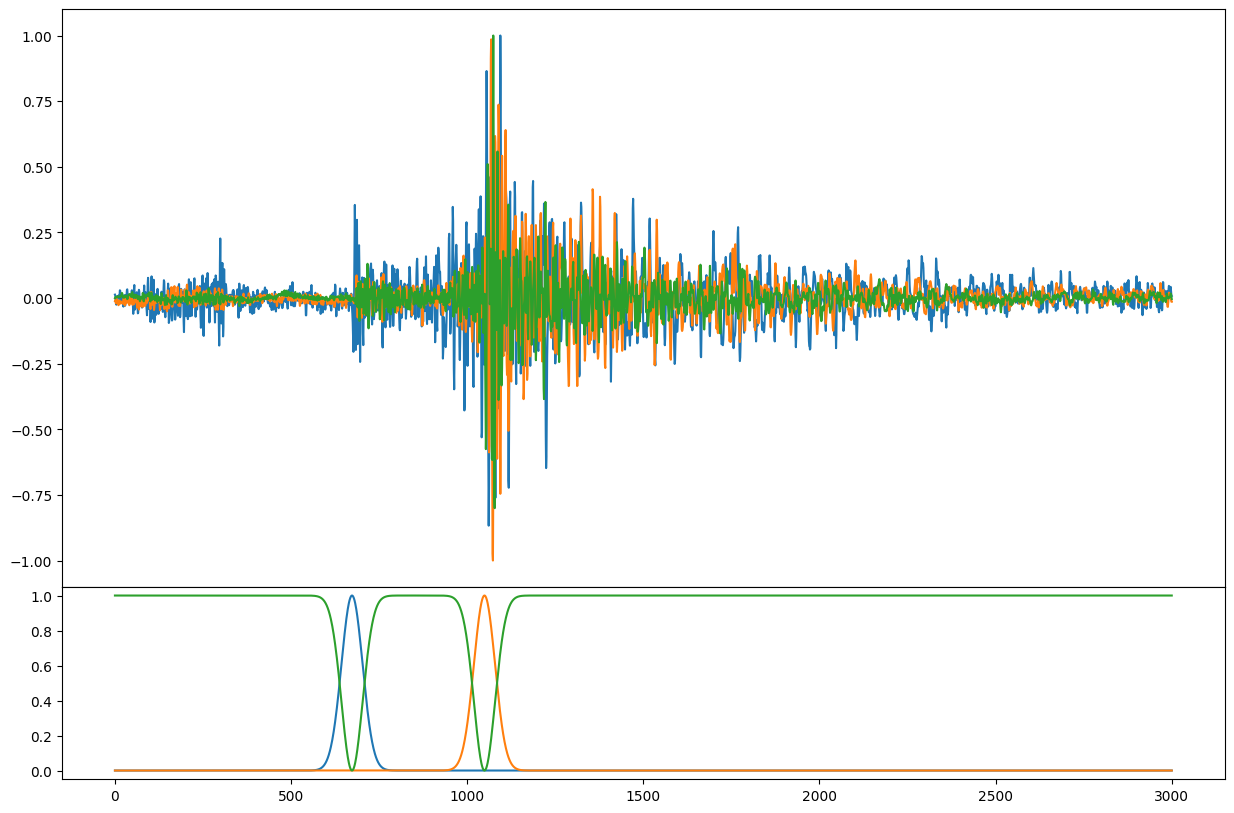

In [9]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

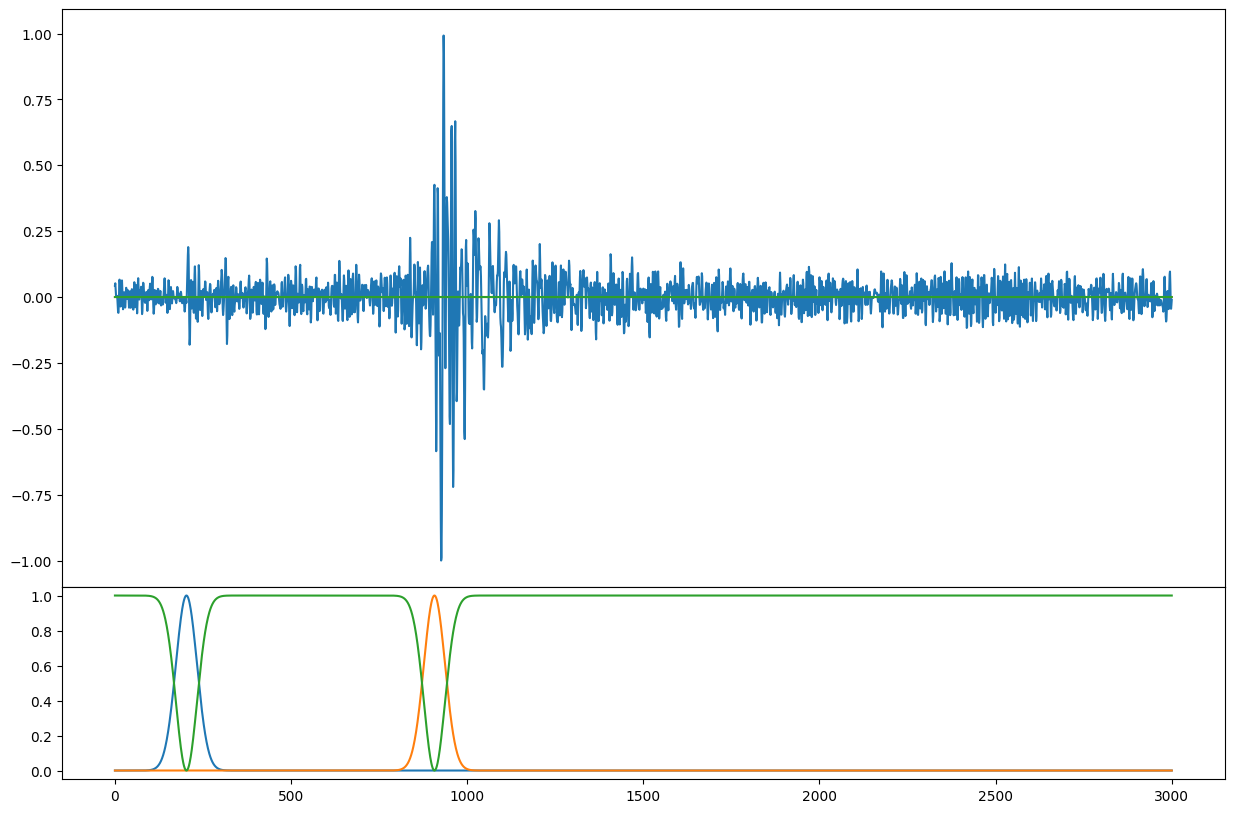

In [10]:
sample = val_generator[np.random.randint(len(val_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

In [11]:
from seisbench.util import worker_seeding

batch_size = 64
num_workers = 4  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
val_loader = DataLoader(val_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

# training

In [12]:
def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device {device}")
model = UNet1D().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(device))
        loss = loss_fn(pred, batch["y"].to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    model.eval()  # close the model for evaluation

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(device))
            test_loss += loss_fn(pred, batch["y"].to(device)).item()

    model.train()  # re-open model for training stage

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

device cpu


In [14]:
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(val_loader)

Epoch 1
-------------------------------
loss: 0.903041  [    0/14912]
loss: 0.874335  [  320/14912]
loss: 0.851546  [  640/14912]
loss: 0.784916  [  960/14912]
loss: 0.421416  [ 1280/14912]
loss: 0.296770  [ 1600/14912]
loss: 0.245345  [ 1920/14912]
loss: 0.231364  [ 2240/14912]
loss: 0.214206  [ 2560/14912]
loss: 0.214403  [ 2880/14912]
loss: 0.225916  [ 3200/14912]
loss: 0.213509  [ 3520/14912]
loss: 0.211765  [ 3840/14912]
loss: 0.217887  [ 4160/14912]
loss: 0.215997  [ 4480/14912]
loss: 0.219781  [ 4800/14912]
loss: 0.212953  [ 5120/14912]
loss: 0.208836  [ 5440/14912]
loss: 0.218127  [ 5760/14912]
loss: 0.208130  [ 6080/14912]
loss: 0.211972  [ 6400/14912]
loss: 0.217898  [ 6720/14912]
loss: 0.211242  [ 7040/14912]
loss: 0.211338  [ 7360/14912]
loss: 0.215619  [ 7680/14912]
loss: 0.213561  [ 8000/14912]
loss: 0.202786  [ 8320/14912]
loss: 0.204012  [ 8640/14912]
loss: 0.190811  [ 8960/14912]
loss: 0.207878  [ 9280/14912]
loss: 0.200124  [ 9600/14912]
loss: 0.188676  [ 9920/14912]


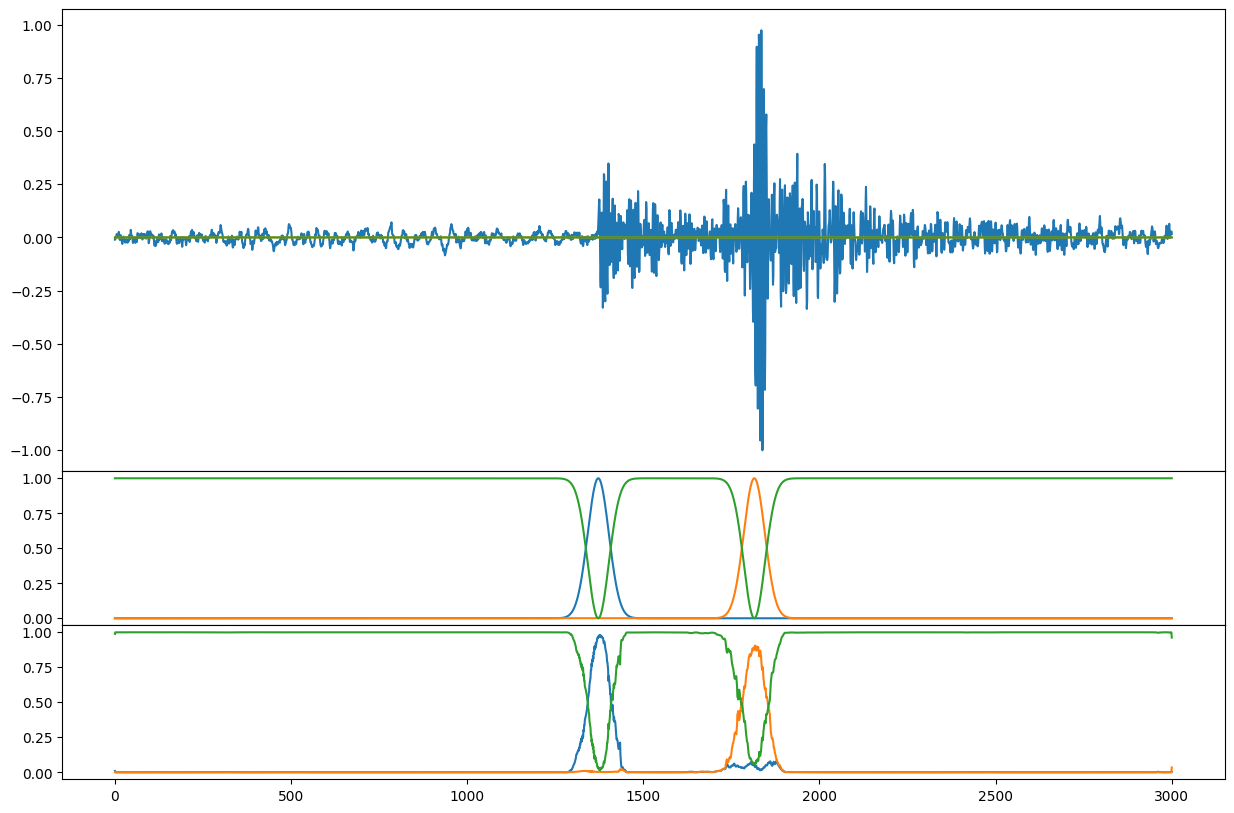

In [16]:
sample = test_generator[np.random.randint(len(test_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

model.eval()  # close the model for evaluation

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)

In [17]:
torch.save(model.state_dict(), "model_weights.pt")
torch.save(model, "fullmodel_with_architacture.pt")

# Load model for ref

In [18]:
model = UNet1D()
model.load_state_dict(torch.load("model_weights.pt"))
model.eval()  # set to eval mode for inference

UNet1D(
  (downs): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (2): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (3): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU